In [1]:
from dotenv import load_dotenv
import os
from langchain_groq import ChatGroq
load_dotenv()
GROQ_API_KEY=os.environ.get("GROQ_API_KEY")

TRACELOOP_API_KEY= os.environ.get("TRACELOOP_API_KEY")

llm =ChatGroq(model ="llama-3.3-70b-versatile")

# Set inmemory llm cache
from langgraph.cache.memory import InMemoryCache

In [2]:
from typing import TypedDict,Literal,Annotated
from pydantic import BaseModel,Field
import operator

class TweetState(TypedDict):
    topic :str
    tweet: str
    evaluation: Literal["Approved","Need_Improvement"]
    feedback :str
    iteration: int
    max_iteration: int
    tweet_history: Annotated[list[str],operator.add]
    feedback_history: Annotated[list[str],operator.add]


class TweetEvaluatior(BaseModel):
    evaluation:Literal["Approved","Need_Improvement"]= Field(...,descripton ="Final Evaluation Result")
    feedback: str = Field(...,description = "Feedback for tweet") 

In [3]:
structured_evaluation_llm=llm.with_structured_output(TweetEvaluatior)

In [4]:
#Tweet Generator
from langchain_core.messages import SystemMessage,HumanMessage
def Generator(state:TweetState):
    messages = [
        SystemMessage(content="You are a funny and clever Twitter/X influencer."),
        HumanMessage(content=f"""
Write a short, original, and hilarious tweet on the topic: "{state['topic']}".

Rules:
- Do NOT use question-answer format. 
- Max 280 characters.
- Use observational humor, irony, sarcasm, or cultural references.
- Think in meme logic, punchlines, or relatable takes.
- Use simple, day to day english
""")
    ]

    response =llm.invoke(messages).content

    return {"tweet":response,"tweet_history":[response]}

In [5]:
  # prompt
def Evaluator(state:TweetState):
    messages = [
    SystemMessage(content="You are a ruthless, no-laugh-given Twitter critic. You evaluate tweets based on humor, originality, virality, and tweet format."),
    HumanMessage(content=f"""
Evaluate the following tweet:

Tweet: "{state['tweet']}"

Use the criteria below to evaluate the tweet:

1. Originality – Is this fresh, or have you seen it a hundred times before?  
2. Humor – Did it genuinely make you smile, laugh, or chuckle?  
3. Punchiness – Is it short, sharp, and scroll-stopping?  
4. Virality Potential – Would people retweet or share it?  
5. Format – Is it a well-formed tweet (not a setup-punchline joke, not a Q&A joke, and under 300 characters)?

Auto-reject if:
- It's written in question-answer format (e.g., "Why did..." or "What happens when...")
- It exceeds 300 characters
- It reads like a traditional setup-punchline joke
- Dont end with generic, throwaway, or deflating lines that weaken the humor (e.g., “Masterpieces of the auntie-uncle universe” or vague summaries)

### Respond ONLY in structured format:
- evaluation: "approved" or "needs_improvement"  
- feedback: One paragraph explaining the strengths and weaknesses 
""")
]
    
    response = structured_evaluation_llm.invoke(messages)

    return {"evaluation":response.evaluation,"feedback":response.feedback,"feedback_history":[response.feedback]}

In [6]:
def Optimizer(state: TweetState):
    messages = [
        SystemMessage(content="You punch up tweets for virality and humor based on given feedback."),
        HumanMessage(content=f"""
Improve the tweet based on this feedback:
"{state['feedback']}"

Topic: "{state['topic']}"
Original Tweet:
{state['tweet']}

Re-write it as a short, viral-worthy tweet. Avoid Q&A style and stay under 280 characters.
""")
    ]

    response = llm.invoke(messages).content
    iteration = state['iteration'] + 1

    return {"tweet":response,"iteration":iteration}

In [7]:
def conditional(state:TweetState):
    if state["evaluation"] == "Approved" or state["iteration"] >= state["max_iteration"]:
        return "Approved"
    else:
        return "Need_Improvement" 

In [8]:
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver
memory=MemorySaver()
workflow =StateGraph(TweetState)

# add the  nodes
workflow.add_node("GenerateTweet",Generator)
workflow.add_node("OptimizeTweet",Optimizer)
workflow.add_node("EvaluateTweet",Evaluator)
# Add the Edges
workflow.add_edge(START,"GenerateTweet")
workflow.add_edge("GenerateTweet","EvaluateTweet")
workflow.add_conditional_edges("EvaluateTweet",conditional ,{"Approved":END,"Need_Improvement":"OptimizeTweet"})
workflow.add_edge("OptimizeTweet","EvaluateTweet")
graph=workflow.compile(checkpointer=memory)

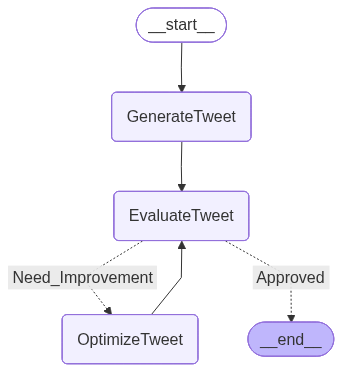

In [9]:
from IPython.display import Image,display
display(Image(graph.get_graph().draw_mermaid_png()))

In [15]:
config={"configurable":{"thread_id":"2"}}
initial_state = {
    "topic": "what is my name?",
    "iteration": 1,
    "max_iteration": 5
}
result = graph.invoke(initial_state,config=config)

In [16]:
result

{'topic': 'what is my name?',
 'tweet': '"My name is probably on a Starbucks cup somewhere, let\'s be real" #NameSearch',
 'evaluation': 'Approved',
 'feedback': "This tweet is a great example of originality and humor, as the idea of one's name being on a Starbucks cup somewhere is a relatable and amusing concept. The tweet is also punchy and concise, making it scroll-stopping and engaging. The use of the hashtag #NameSearch adds to its virality potential, and the format is well-formed, making it a strong tweet overall. The tweet's strength lies in its ability to evoke a chuckle and make the reader smile, which is a key aspect of a successful tweet.",
 'iteration': 1,
 'max_iteration': 5,
 'tweet_history': ["amir is that one friend who's always '5 mins away' but still manages to arrive an hour late",
  "just realized i'm not a morning person, i'm not a night person, i'm an 'am i still asleep?' person",
  '"My name is probably on a Starbucks cup somewhere, let\'s be real" #NameSearch'],

In [17]:
result["tweet_history"]

["amir is that one friend who's always '5 mins away' but still manages to arrive an hour late",
 "just realized i'm not a morning person, i'm not a night person, i'm an 'am i still asleep?' person",
 '"My name is probably on a Starbucks cup somewhere, let\'s be real" #NameSearch']